## Overview
This is my attempt for the first assignment of the Machine Learning course Fall 2022.

### Note
Please make sure the dataset is saved in the ***same working directory*** as this jupyter notebook

## Preliminary: imports and loading data
In this section, I load the data, import the necessary libraries needed for the rest of the notebook. 

In [64]:
import os
import math
import sklearn as sk
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import re
# setting seaborn to darkgrid for a more detailed display of the values
STYLE = 'darkgrid'
sns.set_style(STYLE)

In [65]:
wd = os.getcwd()
dataset_name = "a1_dataset.csv"
file_path = os.path.join(wd, dataset_name) # setting the location of the file 

In [66]:
df_org = pd.read_csv(file_path) # save original datafrae 
df = df_org.copy() # copy to work on

## Exploring the data 
In this section, I explore the dataset, prepare it: (data cleaning and preprocessing), analyse a number of aspects and interations in the data before building models for our prediction purposes 
### Preprocessing the data

In [67]:
print(df.shape)
print(df.columns)
df.info() # the only column with missing values is 'var4'

(925, 8)
Index(['target', 'var1', 'var2', 'var3', 'var4', 'var5', 'var6', 'var7'], dtype='object')
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 925 entries, 0 to 924
Data columns (total 8 columns):
 #   Column  Non-Null Count  Dtype  
---  ------  --------------  -----  
 0   target  925 non-null    int64  
 1   var1    925 non-null    float64
 2   var2    925 non-null    float64
 3   var3    925 non-null    object 
 4   var4    325 non-null    float64
 5   var5    925 non-null    float64
 6   var6    925 non-null    object 
 7   var7    925 non-null    object 
dtypes: float64(4), int64(1), object(3)
memory usage: 57.9+ KB


In [68]:
# let's rename the columns
new_names = {"target": "y"}
y = df['target']
for i in range(1, len(df.columns) + 1):
    new_names[f'var{str(i)}'] = f"f{str(i)}"
df = df.rename(columns=new_names)
print(df.columns)
# I will drop the target column and add it to the dataframe when needed
df.drop('y', inplace=True, axis=1)

Index(['y', 'f1', 'f2', 'f3', 'f4', 'f5', 'f6', 'f7'], dtype='object')


### Target variable distribution

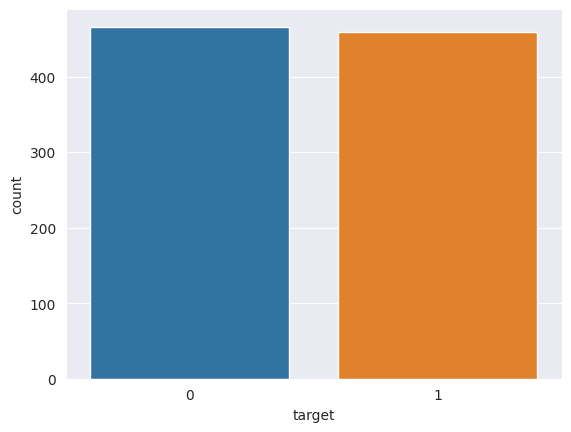

In [69]:
sns.countplot(x=y)
plt.show()

### Numerical and categorial columns
It is crucial to divide the data into categorical and numerical columns as each column should be treated differently. In this subsection, I perform this task in a systematic way:

In [70]:
# this method returns a tuple of the column names : numerical then categorical
def num_cat(df):
    num = df.select_dtypes(np.number).columns.values
    cat = df.select_dtypes(['object', 'category']).columns.values
    return num, cat


num_cols, cat_cols = num_cat(df)

### Understanding the data: visualization, grouping, descriptive analysis

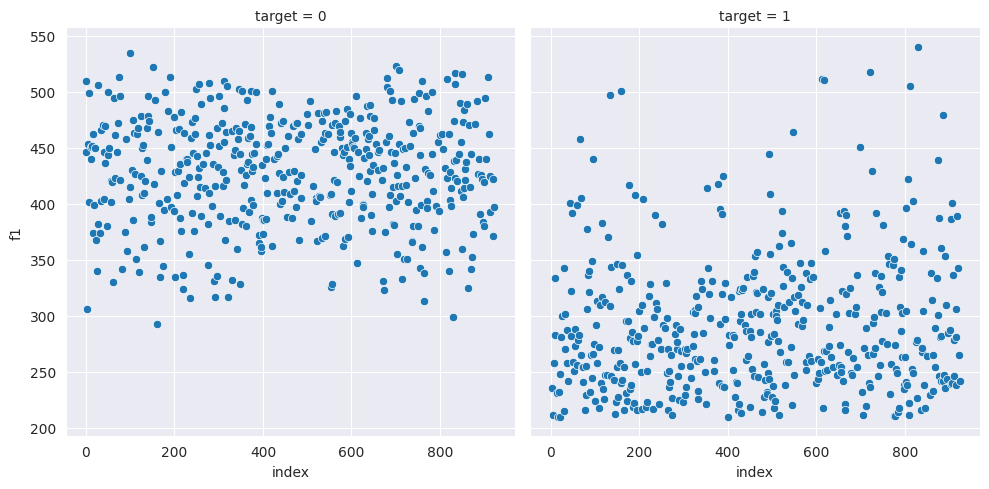

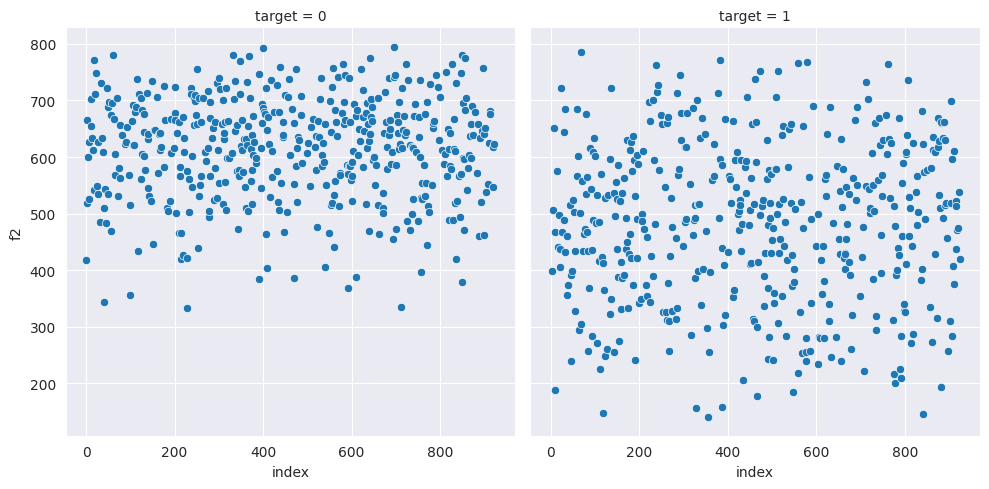

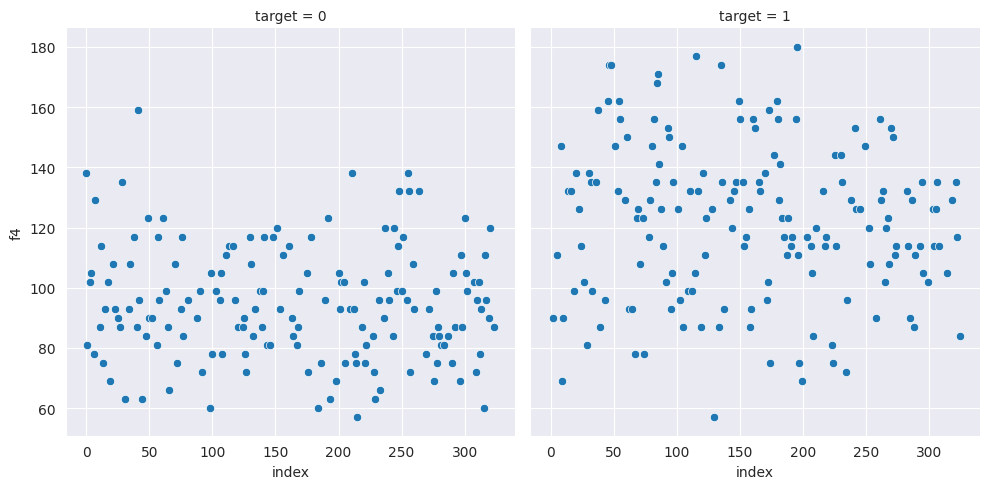

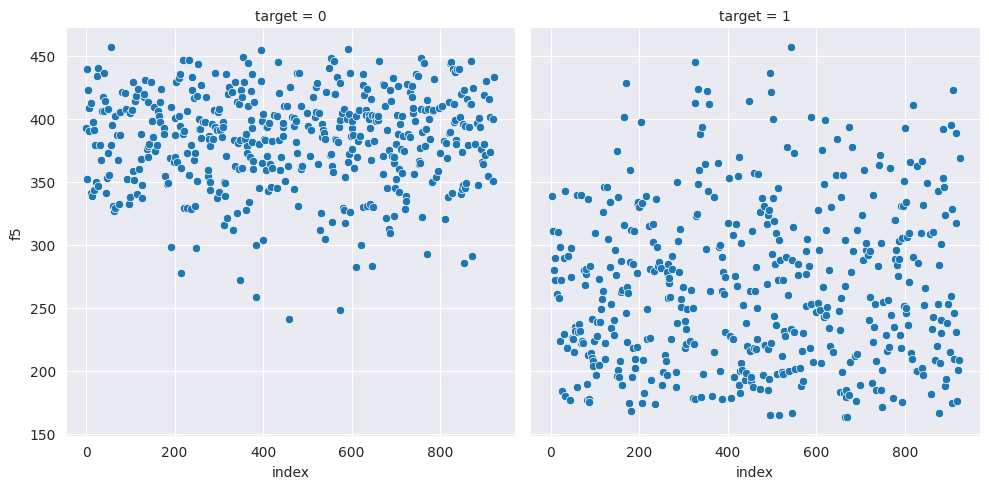

In [71]:
# this method is short for first impression numerical, where I consider the values and its effect 
def first_imp_num(df, y, col_name):
    df_c = df.dropna(axis=1).copy() # a copy with non Nan values
    f1_fig = sns.relplot(data=df, x=df_c.index.values, y=col_name, col=y, col_order=[0, 1])
    f1_fig.set(xlabel="index", ylabel=col_name)
    plt.show()

for col in num_cols:
    first_imp_num(df, y, col)


In [72]:
# analysing the numerical columns
from empiricaldist import Cdf
    
def cdf_num(df, y, col_name, target=False):
    df_c = df.dropna(axis=0).copy() # take a copy with no nan values in it.
    df_c['y'] = y.copy()
    if not target:
        col_cdf = Cdf.from_seq(df[col_name])
        col_cdf.plot()
        plt.xlabel(f'{col_name}')
        plt.ylabel(f'CDF for {col_name}')
        plt.show()         
    else :    
        cdf_1 = Cdf.from_seq(df_c[df_c['y'] == 1][col_name])
        cdf_0 = Cdf.from_seq(df_c[df_c['y'] == 0][col_name])
        cdf_1.plot(label='y == 1')
        cdf_0.plot(label='y == 0')
        plt.xlabel(f'{col_name}')
        plt.ylabel(f'CDF for {col_name}')
        plt.legend()
        plt.show()        

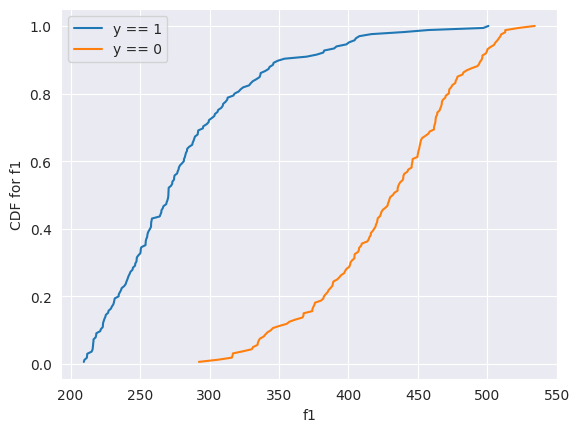

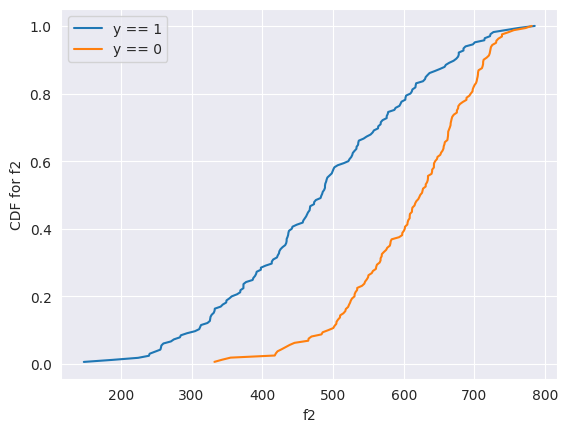

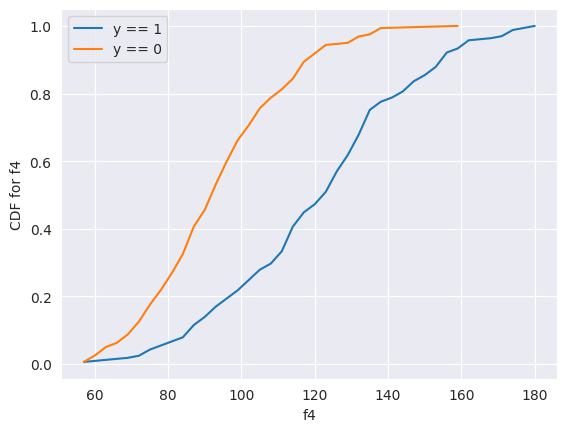

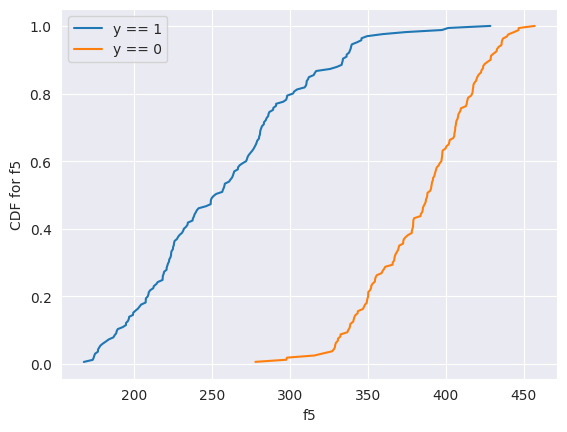

In [73]:
for col in num_cols:
    cdf_num(df, y, col, target=True)

#### Conclusion: 
considering all numerical features (except for f4), negative examples tend to have high values for such features. The column f4 is not as informative as no clear trend or correlation (linear or non-linear) can be seen. This is possibly the result of the large number of missing values.

### Analysing categorical features
The features f3, f6 and f7 are categorical features. The interacations should be understood in depth.

#### Fixing f7
As the 'f7' includes invalid dates, more preprocessing steps should be taken.

In [74]:
# let's set the last column to datetime for further manipulation
try:    
    df['f7'] = pd.to_datetime(df['f7']) 
except:
    print("Certain dates are semantically invalid")
    
from dateutil import parser

# for futher manipulation we need to determine the invalid dates
def validate_dates(row):
    try:
        row['valid_date'] = parser.parse(row['f7']) # if the data isinvalid an error will raise,
    except ValueError:
        row['valid_date'] = False # the except block will catch it and set the field to False
    return row

df = df.apply(validate_dates, axis=1)
invalid_dates = df[df['valid_date'] == False]['f7'].values

Certain dates are semantically invalid


In [75]:
print(invalid_dates) # this is the list of invalid dates in the dataframes
# let's reduce these dates by 24 hours

def fix_dates(row):
    if row['f7'] in invalid_dates:
        date, time = row['f7'].split()
        # change the 29 to 28
        date = date[:-2] + "28"
        row['f7'] = date + " " + time
    return row

df = df.apply(fix_dates, axis=1)

df['f7'] = pd.to_datetime(df['f7'])

['2019-02-29 12:31:57' '2019-02-29 18:06:21' '2019-02-29 11:00:06'
 '2019-02-29 23:56:06' '2019-02-29 19:26:35']


In [76]:
print(df.dtypes)
# now that the 7th column is converted to datetime, we can futher break it down and tackle each component of the date: year, month, day, time
year = 'year'
month = 'month'
day = 'day'
time = 'time'
date_cols = [year, month, day, time]
def decompose_date(row):
    row[year] = row['f7'].year
    row[month] = row['f7'].month
    row[day] = row['f7'].day
    row[time] = row['f7'].time
    return row

df = df.apply(decompose_date, axis=1)
print()

f1                   float64
f2                   float64
f3                    object
f4                   float64
f5                   float64
f6                    object
f7            datetime64[ns]
valid_date            object
dtype: object



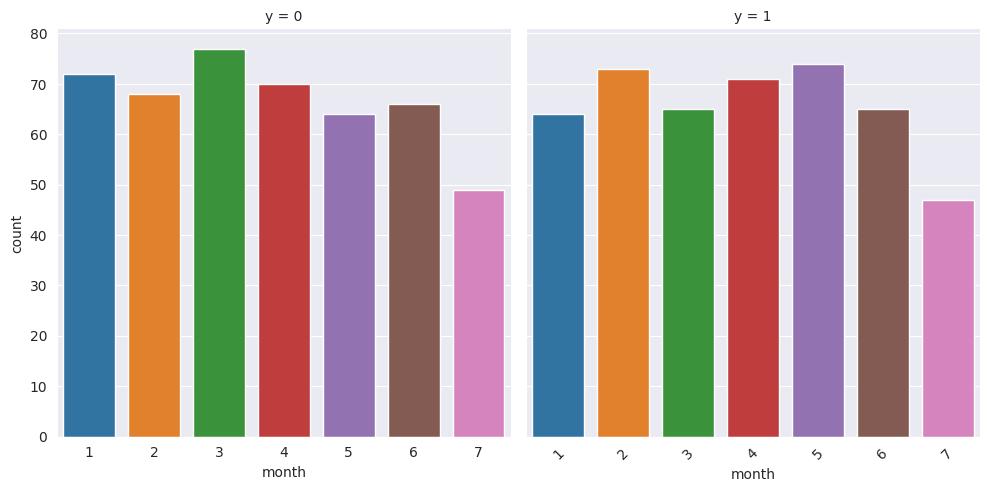

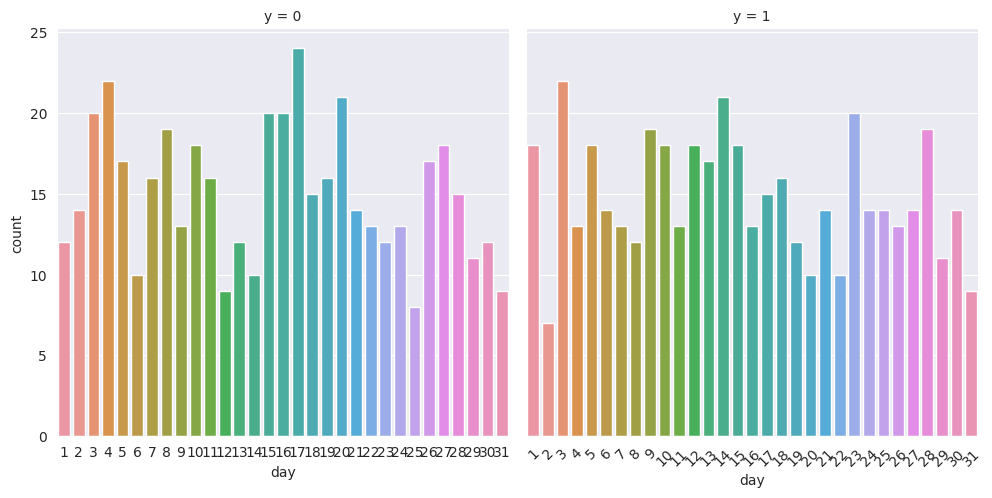

In [77]:
for c in date_cols[1:-1]:
    df_c = df.copy()
    df_c['y'] = y
    fig = sns.catplot(data=df_c, kind='count', x=c, col='y', col_order=[0, 1])
    fig.set(xlabel=c, ylabel='count')
    plt.xticks(rotation=45)
    plt.show()

In [78]:
# the only year present is 2019. The data concerns countries so time within a single day cannot be significant
# year and time columns are to be dropped
df = df.drop(year, axis=1)
df = df.drop(time, axis=1)

In [79]:
# let's consider the number of positively classed examples within each month
df['y'] = y.copy()
print(pd.pivot_table(df, index=month, values='y', aggfunc=['count', 'mean']))
# we can see that the month's value does not affect the class distribution

      count      mean
          y         y
month                
1       136  0.470588
2       141  0.517730
3       142  0.457746
4       141  0.503546
5       138  0.536232
6       131  0.496183
7        96  0.489583


#### 'f3' Column
As the column 'f3' represents countries' (areas') names, it is recommended to normalize the string representation and remove any unnecessary characters.

In [80]:
def clean_country(row):
    row['f3'] = row['f3'].strip().lower()
    # remove any string between parentheses if they exist
    row['f3'] = re.sub('\(.*\)', "", row['f3'])
    # remove any string between brackets if they exist
    row['f3'] = re.sub('\[.*\]', "", row['f3'])
    return row

df = df.apply(clean_country, axis=1)

In [81]:
# set date with the rest of the columns
def set_date(row):
    row['date'] = pd.Timestamp(year=2019, month=row[month], day=row[day])
    return row

In [82]:
# let's encode f6 as no:0 and yes:1
print(df['f6'].value_counts())
# the column's integrity is verified
encode_dict = {"no":0, "yes":1}
df['f6'] = df['f6'].apply(encode_dict.get)

# for f in num_cols:
#     print(pd.pivot_table(df, index='f3', columns=month, values=f, aggfunc=[np.mean]))
# print(pd.pivot_table(df, index='f3', columns=month, values='f6', aggfunc=[np.mean]))

f1_trend = pd.pivot_table(df, index='f3', columns=month, values='f1', aggfunc=[np.mean])
f2_trend = pd.pivot_table(df, index='f3', columns=month, values='f2', aggfunc=[np.mean])
f4_trend = pd.pivot_table(df, index='f3', columns=month, values='f4', aggfunc=[np.mean])
f5_trend = pd.pivot_table(df, index='f3', columns=month, values='f5', aggfunc=[np.mean])
f6_trend = pd.pivot_table(df, index='f3', columns=month, values='f6', aggfunc=[np.mean])

yes    483
no     442
Name: f6, dtype: int64


In [83]:
# let's account the ratio of times each country was classified positively
country_y_ratio = pd.pivot_table(df, index='f3', values='y', aggfunc=['count', 'mean']).sort_values(by=[('mean', 'y'), ('count', 'y')], ascending=[False, False])
print(country_y_ratio) 

              count mean
                  y    y
f3                      
ethiopia          6  1.0
hungary           5  1.0
kenya             4  1.0
latvia            4  1.0
liechtenstein     4  1.0
...             ...  ...
cape verde        1  0.0
haiti             1  0.0
jordan            1  0.0
lesotho           1  0.0
mozambique        1  0.0

[236 rows x 2 columns]


#### f3 Encoding
The dataframe displayed by the cell above represents the basis for an adequate target encoding of the 'f3' feature. The proposed encoding is:
$\begin{align} count \cdot ratio \end{align}$
* count: the country's number of occurrences
* ratio: the ratio of positive classes associated with these occurrences

In [84]:
# let's investigate the effect of the months and days further.
f1_trend = pd.pivot_table(df, index='f3', columns=y, values='f1', aggfunc=[np.mean, np.median, 'count'])
f2_trend = pd.pivot_table(df, index='f3', columns=y, values='f2', aggfunc=[np.mean, np.median,'count'])
f4_trend = pd.pivot_table(df, index='f3', columns=y, values='f4', aggfunc=[np.mean, np.median, 'count'])
f5_trend = pd.pivot_table(df, index='f3', columns=y, values='f5', aggfunc=[np.mean, np.median, 'count'])

print(f1_trend)
print(f2_trend)
print(f4_trend)
print(f5_trend)


                         mean              median         count     
target                      0           1       0       1     0    1
f3                                                                  
afghanistan        448.550000  268.615000  448.55  270.49   2.0  4.0
albania            446.993333  272.860000  476.12  273.04   3.0  4.0
algeria            406.720000  299.766667  388.74  291.70   3.0  3.0
american samoa     419.490000  281.506667  419.49  264.16   2.0  3.0
andorra                   NaN  340.410000     NaN  340.41   NaN  2.0
...                       ...         ...     ...     ...   ...  ...
wallis and futuna  459.713333  218.580000  451.98  218.58   3.0  1.0
western sahara     397.220000  289.190000  397.22  282.00   2.0  4.0
yemen              334.520000  250.770000  334.52  250.77   1.0  2.0
zambia             423.740000  264.393333  423.74  270.62   1.0  3.0
zimbabwe           408.320000  277.655000  408.32  276.93   2.0  4.0

[236 rows x 6 columns]
          

#### Month, area(f3) and target
In this section I will study the effect of the combination: month, area, and target class on the different numerical values (except 'f4').
The procedure can be described as follows:
* separate the positive and negative rows into two dataframes
* for each dataframe group the rows by 'f3' and aggregate a given numerical feature on the month column: calculate the mean value at each month by country (area/f3)
* visualize the evolution of the mean with respect to month column


The mean in this case is a representative statistic as there is a less than 3 values for each combination of (country, month)

In [85]:
import random
df_1 = df[df['y'] == 1]
df_0 = df[df['y'] == 0]


def feat_month_country(feat, aggs=None, num_display=2, num_samples=20):
    if aggs is None:
        aggs = [np.mean]
    # visualize positive 
    f_months1 = pd.pivot_table(df_1, index='f3', columns=month, values=feat, aggfunc=[np.mean]) # calculate the mean of the feature accross different months for positive rows
    f_months0 = pd.pivot_table(df_0, index='f3', columns=month, values=feat, aggfunc=[np.mean]) # calculate the mean of the feature accross different months for negative rows

    for i in range(1, num_display + 1):
        c0 = f_months1.index.values.tolist()
        c0_sample = random.sample(c0, min(num_samples, len(c0))) 

        for c in c0_sample:
            g = sns.lineplot(x=range(1, 8), y=f_months1.loc[c,:])
        g.set(xlabel='months', ylabel=feat, label=c)
        g.set_title(f"evolution of {feat} with respect to months for positive areas: plot {str(i)}")
        plt.show()
        
    # visualize negative
    for i in range(1, num_display + 1):
        c0 = f_months0.index.values.tolist()
        c0_sample = random.sample(c0, min(num_samples, len(c0))) 

        for c in c0_sample:
            g = sns.lineplot(x=range(1, 8), y=f_months0.loc[c,:])
        g.set(xlabel='months', ylabel=feat, label=c)
        g.set_title(f"evolution of {feat} with respect to months for negative areas: plot {str(i)}")
        plt.show()
    

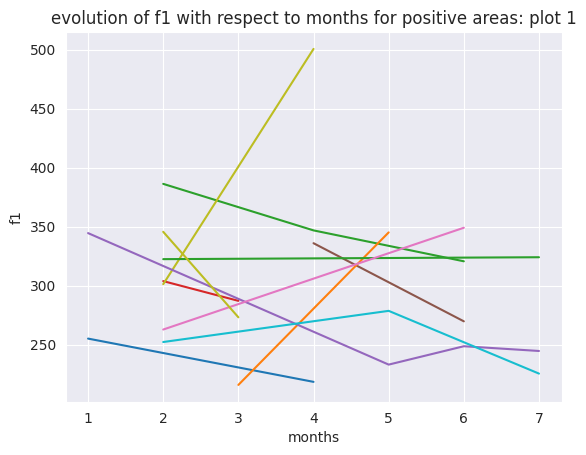

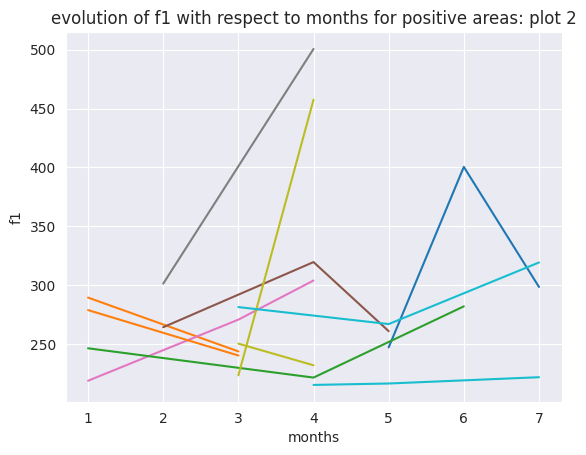

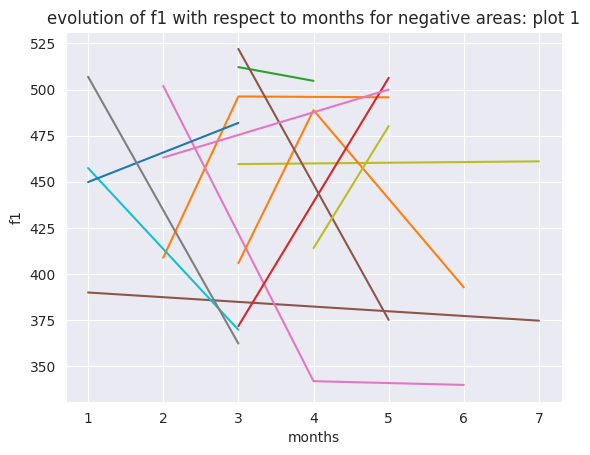

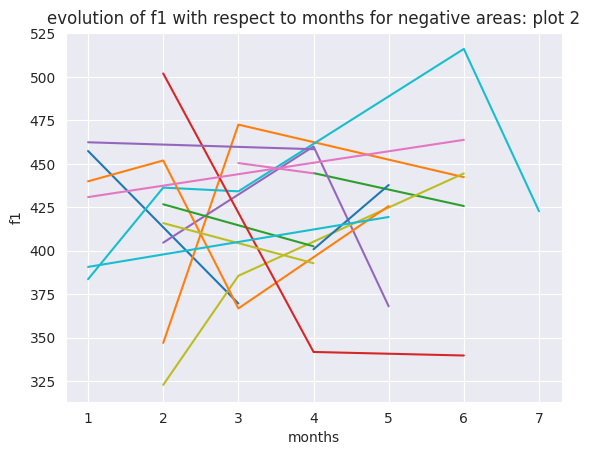

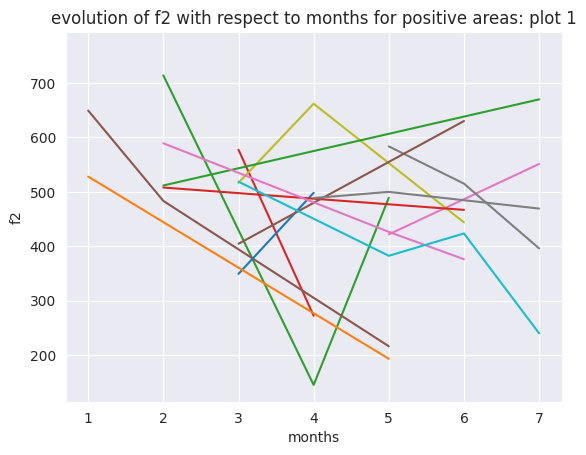

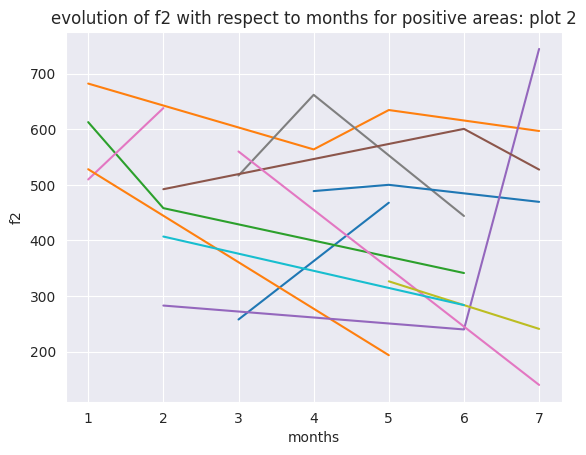

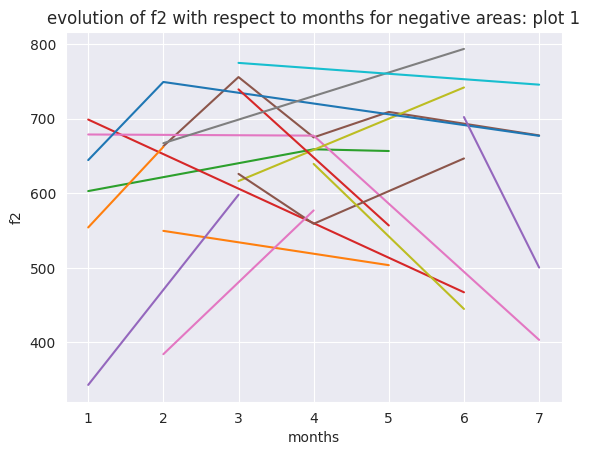

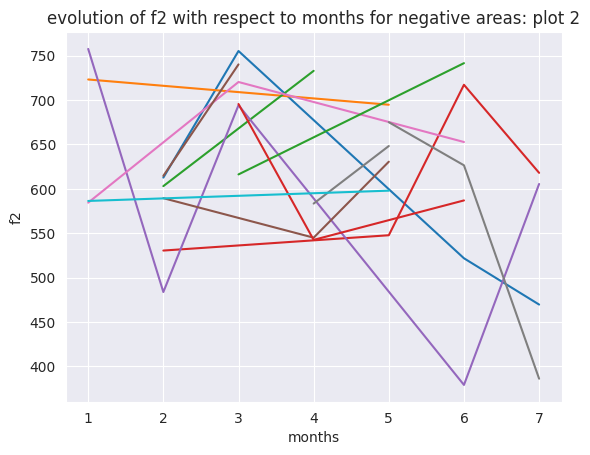

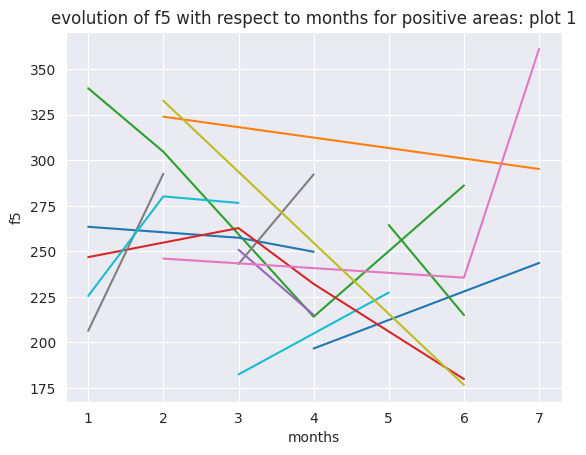

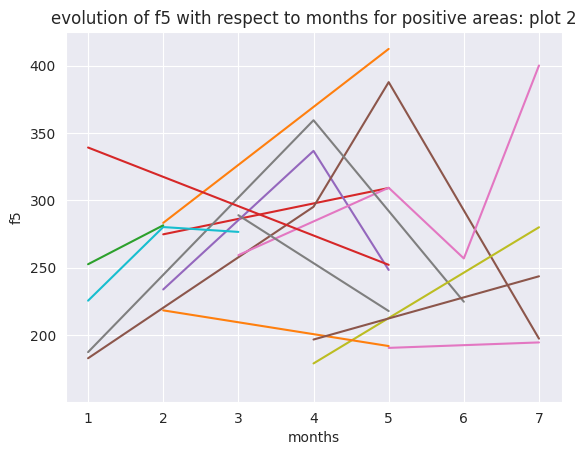

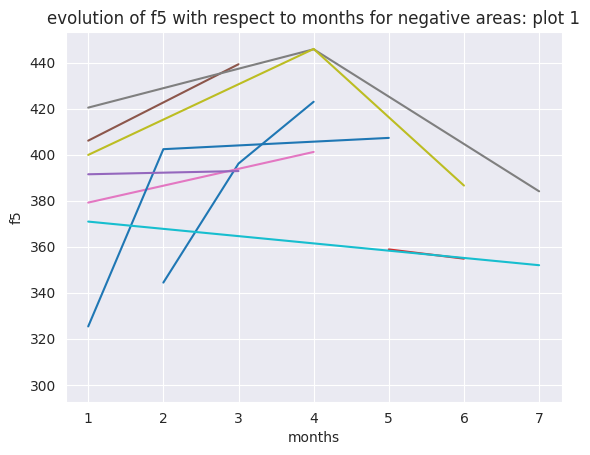

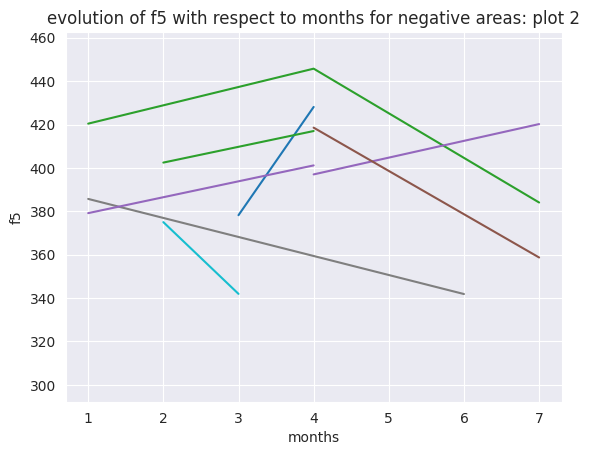

In [86]:
cols = ['f1', 'f2', 'f5']
for c in cols:
    feat_month_country(c)

In [91]:
# print(pd.pivot_table(df, index='f3', columns=month, values='f6', aggfunc=['count']))
# print(pd.pivot_table(df, index='f3', columns=month, values='f6', aggfunc=['mean']))
print(pd.pivot_table(df, index='f3',values='f6',aggfunc=['count', 'mean']))

                  count      mean
                     f6        f6
f3                               
afghanistan           6  1.000000
albania               7  0.571429
algeria               6  0.833333
american samoa        5  0.800000
andorra               2  0.000000
...                 ...       ...
wallis and futuna     4  0.500000
western sahara        6  0.666667
yemen                 3  1.000000
zambia                4  0.250000
zimbabwe              6  0.666667

[236 rows x 2 columns]


The visualization display chaotric interaction between the different features grouped by the country ('f3') column and the date column ('f7'). 
Thus, we can safely assume the month + country combination has little to no correlation with the numerical features.

In [87]:
# let's consider the evolution of different values with respect to the months regardless of the country column
# we can acheive that using box plots
def feat_month(feat, aggs=None):
    if aggs is None:
        aggs = [np.mean]
    f_month = pd.pivot_table(df, index=month, values=feat, aggfunc=aggs)
    for stat in aggs:
        fig = sns.relplot(kind="line", ci=None, data=f_month, x='month', y=f_month[(stat, feat)])
        fig.fig.suptitle(f"{stat}'s variation of {feat} with respect to the month")
    plt.show()

/home/ayhem18/Ayhem18/DEV/Data_science/Towards_Data_Science/ds_env/lib/python3.10/site-packages/seaborn/relational.py:1064: FutureWarning: merging between different levels is deprecated and will be removed in a future version. (2 levels on the left, 1 on the right)
  g.data = pd.merge(


AttributeError: 'FacetGrid' object has no attribute 'set_title'

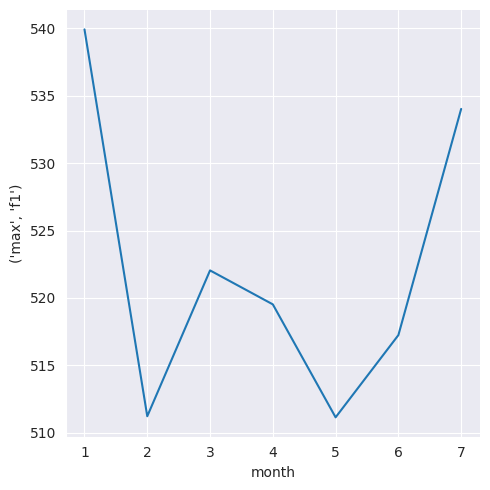

In [88]:
for f in ['f1', 'f2', 'f5']:
    feat_month(f, ['max', 'min', 'mean', 'median'])

#### Conclusion
As we can see from the last two subsections, the date reduced to the month value (as the year is the same across the dataset) does not correlate by any mean with neither the country, target or even the (non-missing) numerical features.  
The only possible use of the 'f7' column is impute the 'f4' missing values (if possible)